<a href="https://colab.research.google.com/github/nikhil-xb/Color-Detection/blob/main/cifar10-7ep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Oct 29 08:27:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# !pip install gdown

In [ ]:
# !gdown --id 1axT7y37L81D-QSvBfSqwIFV9_fPNIiTU

In [2]:
# Importing all the libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms, utils
from PIL import Image
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import time
import os
import copy
import tqdm

In [ ]:
#@title Default title text
# import tarfile
# file= tarfile.open('./cifar-10-python.tar.gz')
# file.extractall('./')
# file.close()

In [ ]:
#@title Default title text
# import pickle 
# def unpickle(file):
#     with open(file, 'rb') as fo:
#         data= pickle.load(fo, encoding="bytes")
#     return data

# def load_cifar_data(dir,negatives=False):

#     meta_data_dict= unpickle(dir+"/batches.meta")
#     label_names= meta_data_dict[b'label_names']
#     cifar_label_names= np.array(label_names)
#     # Training Data
#     cifar_train_data= None
#     cifar_train_labels=[]
#     cifar_train_filenames= []

#     for i in range(1,6):
#         cifar_train_data_dict= unpickle(dir+"/data_batch_{}".format(i))
#         if i==1:
            
#             cifar_train_data= cifar_train_data_dict[b'data']
#         else:
#             cifar_train_data= np.vstack((cifar_train_data, cifar_train_data_dict[b'data']))
#         cifar_train_filenames+= cifar_train_data_dict[b'filenames']
#         cifar_train_labels+= cifar_train_data_dict[b'labels']
#     cifar_train_data= cifar_train_data.reshape(len(cifar_train_data), 3,32,32)

#     if negatives:
#         cifar_train_data = cifar_train_data.transpose(0, 2, 3, 1).astype(np.float32)
#     else:
#         cifar_train_data = np.rollaxis(cifar_train_data, 1, 4)
#     cifar_train_filenames = np.array(cifar_train_filenames)
#     cifar_train_labels = np.array(cifar_train_labels)
    
#     #Testing Data
#     cifar_test_data_dict= None
#     cifar_test_labels= []
#     cifar_test_filenames= []

#     cifar_test_data_dict= unpickle(dir+"/test_batch")
#     cifar_test_data= cifar_test_data_dict[b'data']

#     cifar_test_filenames+= cifar_test_data_dict[b'filenames']
#     cifar_test_labels+= cifar_test_data_dict[b'labels']
#     cifar_test_data= cifar_test_data.reshape(len(cifar_test_data), 3,32,32)

#     if negatives:
#         cifar_test_data = cifar_test_data.transpose(0, 2, 3, 1).astype(np.float32)
#     else:
#         cifar_test_data = np.rollaxis(cifar_test_data, 1, 4)
#     cifar_test_filenames = np.array(cifar_test_filenames)
#     cifar_test_labels = np.array(cifar_test_labels)

#     return cifar_train_data, cifar_train_labels, cifar_train_filenames, \
#     cifar_test_data, cifar_test_labels, cifar_test_filenames, cifar_label_names



In [ ]:
#@title Default title text
# cifar_10_dir= "./cifar-10-batches-py"
# train_data, train_labels, train_filename, test_data, test_labels, test_filename, label_names = \
#     load_cifar_data(cifar_10_dir)
# print(f"Train Data= {train_data.shape}\nTest Data= {test_data.shape}\nTrain Labels= {train_labels.shape}\nTest Labels= {test_labels.shape}")
# print(f"Labels={label_names.shape}")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
class CifarDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir,class_names,transform=None):
        self.class_names= class_names
        self.transform= transform
        
        self.X= []
        self.Y= []
        i=0
        for class_ in class_names:
            class_dir=os.path.join(data_dir, class_)
            images= os.listdir(class_dir)
            for image in tqdm.tqdm(images):
                image_path= os.path.join(class_dir, image)
                pil_image= Image.open(image_path)
                self.X.append(Image.open(image_path))
                self.Y.append(int(class_names.index(class_)))
                i+=1
    def __getitem__(self,index):
        if torch.is_tensor(index):
            index= index.tolist()
        sample= {'image': self.X[index], 
                'label': self.Y[index]}
        if self.transform:
            sample['image']= self.transform(sample['image'])
            
        return sample
    def __len__(self):
        return len(self.X)
    def getXY(self):
        return self.X, self.Y

In [6]:
!unzip -q '/content/drive/MyDrive/DataSets/Cifar10.zip'

In [7]:
cif_data= CifarDataset(data_dir= '/content/cifar10/cifar10/train',
                      class_names= class_names)

100%|██████████| 5000/5000 [00:00<00:00, 8612.51it/s]


0 (32, 32) airplane


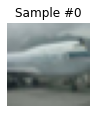

1 (32, 32) airplane


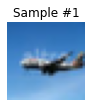

2 (32, 32) airplane


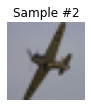

3 (32, 32) airplane


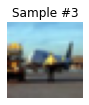

In [8]:
'''dim= 10
fig, ax= plt.subplots(dim,dim)
for m in range(dim):
    for n in range(dim):
        idx= np.random.randint(0, train_data.shape[0])
        ax[m,n].imshow(train_data[idx])
        ax[m,n].get_xaxis().set_visible(False)
        ax[m,n].get_yaxis().set_visible(False)
fig.subplots_adjust(hspace=0.1)
fig.subplots_adjust(wspace=0)
plt.show() '''
fig = plt.figure()

for i in range(len(cif_data)):
    sample = cif_data[i]

    print(i, sample['image'].size, class_names[int(sample['label'])])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'])
    plt.show()

    if i == 3:
        plt.show()
        break

In [9]:
#Applying transformation
# from torchvison.transforms.transforms import ToTensor
transform_data= {
    'train': transforms.Compose([
#         transforms.ToTensor(),
        transforms.Resize((250,250),interpolation=1), #BiLinear Interpolation
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.3), transforms.ColorJitter(contrast=0.2)]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.transforms.RandomErasing(p=0.4, scale= (0.02, 0.09))
    ]),
    'val': transforms.Compose([
#             transforms.ToTensor(),
            transforms.Resize((224,224), interpolation=1),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [10]:
from sklearn.model_selection import train_test_split
# X,y= train_data, train_labels
X,Y= cif_data.getXY()
indices= [t for t in range(50000)]
X_train, X_test, Y_train,Y_test ,train_idx, valid_idx= train_test_split(X,Y,
                                                                        indices,test_size=0.005,stratify=Y,shuffle=True,random_state=0)

In [ ]:
len(Y_train)

49750

In [11]:
#Creating training and validation dataset
train_dataset= torch.utils.data.Subset(cif_data, train_idx)
valid_dataset= torch.utils.data.Subset(cif_data, valid_idx)

In [12]:
# Mapping transformation to splits
class MapDataSet(torch.utils.data.Dataset):
    def __init__(self, dataset,map_fn):
        self.dataset=dataset
#         self.datasetY= datasetY
        self.map= map_fn
    def __getitem__(self, index):
        if self.map:
            x= self.map(self.dataset[index]['image'])
        else: 
            x= self.dataset[index]['image']
        y= self.dataset[index]['label']
        return x,y
        ''' return
            "x": torch.tensor(x, dtype= torch.ByteTensor),
            "y": torch.tensor(y, dtype= torch.ByteTensor),
        } '''
    def __len__(self):
        return len(self.dataset)

In [13]:
Batch_Size= 32
Num_Workers= 4

tng_tf= MapDataSet(train_dataset,transform_data['train'])
tng_load= torch.utils.data.DataLoader(tng_tf, batch_size=32,num_workers=4)

# tng_Y_tf= MapDataSet(trainY_dataset, map_fn=False)
# tngY_load= torch.utils.data.DataLoader(tng_Y_tf, batch_size=Batch_Size,num_workers= Num_Workers )

val_tf= MapDataSet(valid_dataset,transform_data['val'])
val_load= torch.utils.data.DataLoader(val_tf, batch_size=32,num_workers= 4)
                            

# val_Y_tf= MapDataSet(validY_dataset, map_fn=False)
# valY_load= torch.utils.data.DataLoader(val_Y_tf, batch_size=Batch_Size,num_workers= Num_Workers )



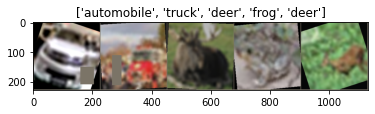

In [14]:
def imshow(inp, title=None):
    inp= inp.numpy().transpose(1,2,0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp= std*inp+mean
    inp= np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes= next(iter(tng_load))

inputs= inputs[:5]
classes= classes[:5]
out= torchvision.utils.make_grid(inputs)

imshow(out,title= [class_names[x] for x in classes])

    

In [26]:
device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataloader= {
    'train': tng_load,
    'val': val_load
}
dataset_size= {
    'train': len(train_dataset),
    'val': len(valid_dataset)
}

In [27]:
def shuffle_minibatch(x,y):
    assert x.size(0)== y.size(0)
    indices= torch.randperm(x.size(0))
    return x[indices], y[indices]

In [28]:
num_batches= dataset_size['train']//Batch_Size
print_every= num_batches//8

def train_model(model, criterion, optimizer, scheduler, num_epochs= 25):
    try:
        since= time.time()
        
        best_model_weights= copy.deepcopy(model.state_dict())
        best_acc=0.0
        
        phase= 'val'
        for epoch in range(num_epochs):
            if phase=='val':
                print('\nEpoch {}/{}'.format(epoch+1,num_epochs))
                print('-'*10)
            time.sleep(1)
            
            for phase in ['train', 'val']:
                if phase=='train':
                    model.train() 
                else:
                    model.eval()
                running_loss= 0.0
                running_corrects= 0
                
                data_loader= dataloader[phase]
                ep_time= time.time()
                
                # Epoch iteration
                for i, (inputs,labels) in enumerate(data_loader):
                    bat_start= time.time()
                    inputs= inputs.to(device)
                    labels= labels.to(device)
                    
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        ## The labels should be a 1d or a 0d 
        
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                    if phase == 'train':
                        if (i+1)%print_every==0:
                            print("\t Batch= {}/{}===>Train Loss {:.4f} and Accuracy {:.4f} at {:.1f}s after start of epoch".format(i+1,num_batches,
                                                                                                                                    running_loss/(Batch_Size*(i+1)),
                                                                                                                                    running_corrects.double()/(Batch_Size*(i+1)),
                                                                                                                                    time.time()- ep_time))
                if phase=="train":
                    scheduler.step()
                epoch_loss= running_loss/dataset_size[phase]
                epoch_acc= running_corrects.double()/ dataset_size[phase]
                
                print('\n{} Loss: {:.4f} Acc: {:.4f}\n'.format(
                    phase, epoch_loss, epoch_acc))

                # deep copy the model
                if phase == 'val' and epoch_acc >= best_acc:
                    best_acc = epoch_acc
                    best_model_weights = copy.deepcopy(model.state_dict())

            print()

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))
        
        # loading best model weights
        model.load_state_dict(best_model_weights)
        return model
    
    except KeyboardInterrupt:
        model.load_state_dict(best_model_weights)
        return model
                    

            

In [ ]:
dir(models)

In [31]:
# Pre trained model
model_ft= models.resnext101_32x8d(pretrained=True)

In [32]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [33]:
import torch.nn.functional as F
class My_Module(nn.Module):
    
    def __init__(self, infeatures, num_classes):
        super(My_Module, self).__init__()
        self.fc1= nn.Linear(infeatures,1024)
        self.fc2= nn.Linear(1024, num_classes)
    def forward(self,x):
        x= self.fc1(x)
        x= nn.Dropout(0.15)(x)
        x= F.relu(x)
        x= self.fc2(x)
        return x
    
last_ftrs= model_ft.fc.in_features
my_module= My_Module(last_ftrs, len(class_names))
my_module

My_Module(
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [34]:
# Adding custom head
model_ft.fc= nn.Sequential(my_module)
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [35]:
criterion= nn.CrossEntropyLoss()
optimizer_ft= optim.SGD(model_ft.parameters(), lr= 0.00001, momentum= 0.9, nesterov=True)

# decaying lr by a factor of 0.1 each 7 epochs
exp_lr_scheduler= lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma= 0.1)

In [36]:
model_ft= model_ft.to(device)

In [25]:
!nvidia-smi

Sat Oct 29 08:48:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W /  70W |    964MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Compelete Training yet to be done (## Load the model for resuming training)

Refer: https://medium.com/analytics-vidhya/saving-and-loading-your-model-to-resume-training-in-pytorch-cb687352fa61

In [23]:
# Saving the model
model_version= 'Ep9.7.pt'
path= F'/content/drive/MyDrive/DataSets/{model_version}'
torch.save(model_ft.state_dict(),path) 
# version 9.7 closed abruptly,,,lead to score loss :(

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)


Epoch 1/50
----------
	 Batch= 194/1554===>Train Loss 1.7826 and Accuracy 0.6493 at 266.2s after start of epoch
	 Batch= 388/1554===>Train Loss 1.7805 and Accuracy 0.6512 at 536.4s after start of epoch
	 Batch= 582/1554===>Train Loss 1.7779 and Accuracy 0.6537 at 806.8s after start of epoch
	 Batch= 776/1554===>Train Loss 1.7767 and Accuracy 0.6526 at 1077.1s after start of epoch
	 Batch= 970/1554===>Train Loss 1.7766 and Accuracy 0.6525 at 1347.6s after start of epoch
	 Batch= 1164/1554===>Train Loss 1.7770 and Accuracy 0.6521 at 1618.0s after start of epoch
	 Batch= 1358/1554===>Train Loss 1.7760 and Accuracy 0.6527 at 1888.0s after start of epoch
	 Batch= 1552/1554===>Train Loss 1.7761 and Accuracy 0.6529 at 2158.7s after start of epoch

train Loss: 1.7760 Acc: 0.6530


val Loss: 1.7821 Acc: 0.7280



Epoch 2/50
----------
	 Batch= 194/1554===>Train Loss 1.7762 and Accuracy 0.6582 at 271.0s after start of epoch
	 Batch= 388/1554===>Train Loss 1.7741 and Accuracy 0.6591 at 541.6s af

In [58]:
# Loading the model
model_version= 'Ep7.pt'
path= F'/content/drive/MyDrive/DataSets/{model_version}'
model_ft.load_state_dict(torch.load(path,map_location=torch.device('cpu'))) 

<All keys matched successfully>

In [65]:
model_ft.eval()
read_img = Image.open(f'/content/cifar10/cifar10/train/airplane/0002.png')
with torch.no_grad():
    read_img = read_img.resize((224,224))
    img_tensor = transforms.ToTensor()(read_img)
    img_tensor = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img_tensor)
    img_tensor = img_tensor.unsqueeze_(0)
    img_tensor = img_tensor.to(device)
    outputs = model_ft(img_tensor)
outputs

tensor([[ 0.3319, -0.3209,  0.0759,  0.1237, -0.3283,  0.0361, -0.0018, -0.3502,
          0.3392, -0.0069]])

In [67]:
MAX_PREDS = 5
# Do not show labels with lower score than this:
MIN_SCORE = 0.5 

def show_preds(logits, image, correct_label=None, class_list=None):

    if len(logits.shape) > 1:
        logits = torch.reshape(logits, [-1])

    fig, axes = plt.subplots(1, 2, figsize=(7, 4), squeeze=False)

    ax1, ax2 = axes[0]
    ax1.imshow(image)
    if correct_label is not None:
        ax1.set_title(class_names[correct_label])
    classes = []
    scores = []
    logits_max = torch.max(logits)

    logits_max, logits = np.array(logits_max.cpu()), np.array(logits.cpu())  
    softmax_denominator = np.sum(np.exp(logits - logits_max))
    for index, j in enumerate(np.argsort(logits)[-MAX_PREDS::][::-1]):
        score = 1.0/(1.0 + np.exp(-logits[j]))
        if score < MIN_SCORE: break
        if class_list is not None:
            classes.append(class_names[j])

        scores.append(np.exp(logits[j] - logits_max)/softmax_denominator*100)

    ax2.barh(np.arange(len(scores)) + 0.1, scores)
    ax2.set_xlim(0, 100)
    ax2.set_yticks(np.arange(len(scores)))
    ax2.yaxis.set_ticks_position('right')
    ax2.set_yticklabels(classes, rotation=0, fontsize=14)
    ax2.invert_xaxis()
    ax2.invert_yaxis()
    ax2.set_xlabel('Prediction probabilities', fontsize=11)

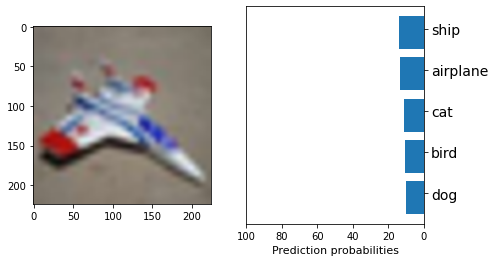

In [68]:
show_preds(outputs, read_img, class_list=class_names)

In [ ]:
old1 = np.load('fin_9830.npy')

In [ ]:
# to make predictions, I used Test time augmentations.
# i used flip, rotate, left 75% crop and right 75% crop.
# THESE ARE THE TEST TIME AUGMENTATIONS I USED.
# THEY ARE COMMENTED OUT BECAUSE OF MY VARIOUS EXPERIMENTS OF WHAT WORKS AND WHAT DOES NOT.

import pandas as pd
import PIL
from tqdm.notebook import tqdm
# helper for images
def preprocess_image(image):

    with torch.no_grad():
        image = image.resize((224,224), resample=PIL.Image.LANCZOS)
        img_tensor = transforms.ToTensor()(image)
        img_tensor = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img_tensor)
        img_tensor = img_tensor.unsqueeze_(0)
        img_tensor = img_tensor.to(device)
    return img_tensor

output = pd.DataFrame(columns=['filename', 'label'])
images_list = sorted(os.listdir('../input/cifar10-pngs-in-folders/cifar10/test'))
old_preds_tense1 = torch.Tensor(old1).to(device)

output_ar = np.zeros((10000, 10))

model_ft.eval()

i = 0
for image in tqdm(images_list):
    image = images_list[i]
    output.loc[i,'filename'] = image

    read_img = Image.open(f'cifar10/test/{image}')
    #read_img_flipped = read_img.transpose(Image.FLIP_LEFT_RIGHT)

    #left_crop = read_img.crop((0, 0, 168, 224))
    #right_crop = read_img.crop((56, 0, 224, 224))

    #read_img_lcrop = left_crop.resize((224,224), resample=PIL.Image.LANCZOS)
    #read_img_rcrop = right_crop.resize((224,224), resample=PIL.Image.LANCZOS)

    with torch.no_grad():
        image1 = preprocess_image(read_img)
        #image2 = preprocess_image(read_img_flipped)
        #image3 = preprocess_image(read_img_lcrop)
        #image4 = preprocess_image(read_img_rcrop)

        image1 = image1.to(device)
        #image2 = image2.to(device)
        #image3 = image3.to(device)
        #image4 = image4.to(device)
 

        outputs1 = model_ft(image1)
        #outputs2 = model_ft(image2)
        #outputs3 = model_ft(image3)
        #outputs4 = model_ft(image4)


        #outputs = (outputs1 + outputs2 + outputs3 + outputs4)/4 

    outputs = (0.8)*old_preds_tense1[i, :] + (0.2)*outputs1
    output_ar[i, :] = outputs.cpu()
    class_ = class_names[int(torch.argmax(outputs))]

    output.loc[i,'label'] = class_

    i += 1

In [ ]:
output['label'].value_counts() # value counts of highest predictions for not repeating the submission again

In [ ]:
output.to_csv('pred.csv', index=False)

In [ ]:
np.save('fin_9833.npy', output_ar)